In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.0-dev20200925


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

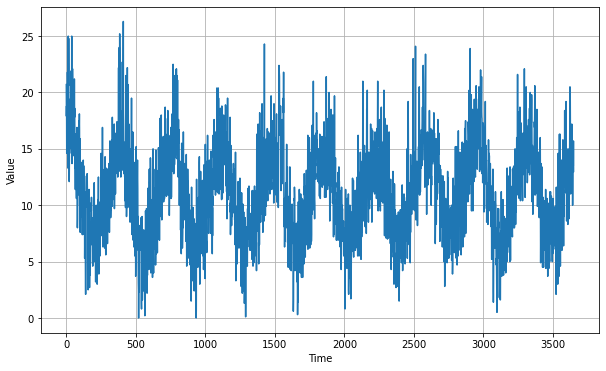

In [3]:
import csv
time_step = []
temps = []

with open('daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile,delimiter=',')
    next(reader)
    step = 0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step+=1
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
split_time = 2500
time_train =time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[:split_time]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=32,strides=1,padding="causal",kernel_size=5,input_shape=[None,1],activation='relu'),
tf.keras.layers.LSTM(64,return_sequences=True),
tf.keras.layers.LSTM(64,return_sequences=True),
tf.keras.layers.Dense(30,activation='relu'),
tf.keras.layers.Dense(10,activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x : x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 9s 273ms/step - loss: 31.0287 - mae: 31.5267
Epoch 2/100
10/10 [==============================] - 3s 259ms/step - loss: 30.7698 - mae: 31.2675
Epoch 3/100
10/10 [==============================] - 3s 258ms/step - loss: 29.9371 - mae: 30.4346
Epoch 4/100
10/10 [==============================] - 3s 242ms/step - loss: 28.6752 - mae: 29.1725
Epoch 5/100
10/10 [==============================] - 3s 243ms/step - loss: 27.2988 - mae: 27.7959
Epoch 6/100
10/10 [==============================] - 3s 246ms/step - loss: 25.7600 - mae: 26.2569
Epoch 7/100
10/10 [==============================] - 3s 248ms/step - loss: 24.0420 - mae: 24.5383
Epoch 8/100
10/10 [==============================] - 3s 271ms/step - loss: 21.3711 - mae: 21.8673
Epoch 9/100
10/10 [==============================] - 3s 246ms/step - loss: 18.2363 - mae: 18.7317
Epoch 10/100
10/

10/10 [==============================] - 3s 237ms/step - loss: 3.2812 - mae: 3.7545
Epoch 85/100
10/10 [==============================] - 3s 234ms/step - loss: 5.1238 - mae: 5.6081
Epoch 86/100
10/10 [==============================] - 3s 228ms/step - loss: 6.4753 - mae: 6.9669
Epoch 87/100
10/10 [==============================] - 2s 213ms/step - loss: 7.3926 - mae: 7.8856
Epoch 88/100
10/10 [==============================] - 2s 224ms/step - loss: 9.1079 - mae: 9.6041
Epoch 89/100
10/10 [==============================] - 3s 253ms/step - loss: 21.2788 - mae: 21.7674
Epoch 90/100
10/10 [==============================] - 2s 214ms/step - loss: 41.0977 - mae: 41.5976
Epoch 91/100
10/10 [==============================] - 2s 229ms/step - loss: 43.3248 - mae: 43.8247
Epoch 92/100
10/10 [==============================] - 3s 238ms/step - loss: 60.6301 - mae: 61.1297
Epoch 93/100
10/10 [==============================] - 2s 226ms/step - loss: 27.8352 - mae: 28.3303
Epoch 94/100
10/10 [=============

(1e-08, 0.0001, 0.0, 60.0)

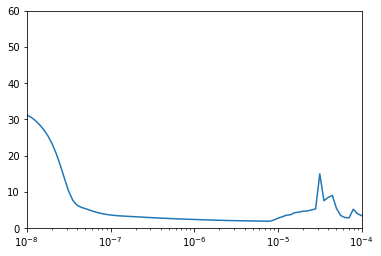

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 9s 122ms/step - loss: 15.8473 - mae: 16.3396
Epoch 2/150
25/25 [==============================] - 3s 117ms/step - loss: 2.9314 - mae: 3.3996
Epoch 3/150
25/25 [==============================] - 3s 117ms/step - loss: 2.0152 - mae: 2.4714
Epoch 4/150
25/25 [==============================] - 3s 121ms/step - loss: 1.9115 - mae: 2.3666
Epoch 5/150
25/25 [==============================] - 3s 122ms/step - loss: 1.8753 - mae: 2.3298
Epoch 6/150
25/25 [==============================] - 3s 124ms/step - loss: 1.8384 - mae: 2.2917
Epoch 7/150
25/25 [==============================] - 3s 117ms/step - loss: 1.8145 - mae: 2.2668
Epoch 8/150
25/25 [==============================] - 3s 121ms/step - loss: 1.7895 - mae: 2.2405
Epoch 9/150
25/25 [==============================] - 3s 117ms/step - loss: 1.7727 - mae: 2.2239
Epoch 10/150
25/25 [==============================] - 3s 123ms/step - loss: 1.7410 - mae: 2.1911
Epoch 11/150
25/25 [=================

25/25 [==============================] - ETA: 0s - loss: 1.5371 - mae: 1.979 - 3s 115ms/step - loss: 1.5359 - mae: 1.9784
Epoch 86/150
25/25 [==============================] - 3s 120ms/step - loss: 1.5327 - mae: 1.9751
Epoch 87/150
25/25 [==============================] - 3s 122ms/step - loss: 1.5347 - mae: 1.9767
Epoch 88/150
25/25 [==============================] - 3s 129ms/step - loss: 1.5338 - mae: 1.9758
Epoch 89/150
25/25 [==============================] - 3s 125ms/step - loss: 1.5299 - mae: 1.9721
Epoch 90/150
25/25 [==============================] - 3s 120ms/step - loss: 1.5380 - mae: 1.9804
Epoch 91/150
25/25 [==============================] - 3s 121ms/step - loss: 1.5291 - mae: 1.9712
Epoch 92/150
25/25 [==============================] - 3s 107ms/step - loss: 1.5300 - mae: 1.9723
Epoch 93/150
25/25 [==============================] - 3s 118ms/step - loss: 1.5270 - mae: 1.9691
Epoch 94/150
25/25 [==============================] - 3s 118ms/step - loss: 1.5341 - mae: 1.9768
Epoch

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [16]:
# plt.figure(figsize=(10, 6))
# plot_series(time_valid, x_valid)
# plot_series(time_valid, rnn_forecast)
print(len(time_valid))
print(len(x_valid))

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

1150
2500


In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.780626

In [ ]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.636601 10.97607  12.159701 ... 13.589686 13.726407 14.940471]
